In [2]:
from chestxray_module.dataset import load_split
import os
import json
import random
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    recall_score,
    confusion_matrix,
    classification_report,
)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
OUT_DIR = Path(f"{os.getcwd()}/reports/best_model/train_reports/")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [20]:
import os
print(os.getcwd())
root_path = r"/home/ramy/Ramy/chestxray"  # Use 'r' before the string to avoid slash errors
os.chdir(root_path)
print(f"Current Directory: {os.getcwd()}")

/home/ramy/Ramy/chestxray
Current Directory: /home/ramy/Ramy/chestxray


In [ ]:


SEED = 42
BATCH_SIZE = 32
NUM_CLASSES = 3
NUM_WORKERS = 0  

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = f"{os.getcwd()}/models/best_model.pt"
OUT_DIR = Path(f"{os.getcwd()}/reports/best_model/eval_reports/")
OUT_DIR.mkdir(parents=True, exist_ok=True)
CLASS_NAMES = ["normal", "pneumonia", "tuberculosis"]

In [45]:
OUT_DIR = Path(f"{os.getcwd()}/reports/best_model/eval_reports/")
OUT_DIR

PosixPath('/home/ramy/Ramy/chestxray/reports/best_model/eval_reports')

In [ ]:

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:

test_dataset = load_split("test")

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)


[INFO] data/interim/cleaned_data already exists.
Transformation done successfully.
1431 images in test_data.


In [60]:
# =============================
# Model
# =============================

model = models.densenet121(weights=None)
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, NUM_CLASSES)
)


model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [68]:
# =============================
# Evaluation loop
# =============================

all_targets = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(DEVICE)
        labels = batch["class"].to(DEVICE)

        logits = model(images)
        probs = torch.softmax(logits, dim=1)

        all_targets.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_targets = np.concatenate(all_targets)
all_probs = np.concatenate(all_probs)
all_preds = np.argmax(all_probs, axis=1)

In [77]:
# =============================
# Metrics
# =============================
# could call helper functions from training script, but need to restructure train.py to allow that
auroc = roc_auc_score(
    all_targets,
    all_probs,
    multi_class="ovr",
    average="macro",
)

f1 = f1_score(all_targets, all_preds, average="macro")
recall_per_class = recall_score(all_targets, all_preds, average=None)

metrics = {
    "auroc_macro": float(auroc),
    "f1_macro": float(f1),
    "recall_normal": float(recall_per_class[0]),
    "recall_pneumonia": float(recall_per_class[1]),
    "recall_tuberculosis": float(recall_per_class[2]),
}

rows = []

for key, value in metrics.items():
    # Case 1: scalar metric
    if np.isscalar(value):
        rows.append({
            "metric": key,
            "class": "all",
            "value": value
        })

    # Case 2: per-class metric (list / array)
    else:
        for i, v in enumerate(value):
            rows.append({
                "metric": key,
                "class": CLASS_NAMES[i],
                "value": float(v)
            })

df_metrics = pd.DataFrame(rows)

print("Final TEST evaluation:")
print(f"  AUROC (macro): {auroc:.4f}")
print(f"  F1 (macro):    {f1:.4f}")
print("  Recall per class:")
for cls, r in zip(CLASS_NAMES, recall_per_class):
    print(f"    {cls}: {r:.4f}")


df_metrics.to_csv(OUT_DIR / "metrics_report.csv", index=False)
print(f"\nmetrics_report.csv saved to: {OUT_DIR.resolve()}")

Final TEST evaluation:
  AUROC (macro): 0.9994
  F1 (macro):    0.9756
  Recall per class:
    normal: 0.9881
    pneumonia: 1.0000
    tuberculosis: 0.9562

metrics_report.csv saved to: /home/ramy/Ramy/chestxray/reports/best_model/eval_reports


In [86]:

cm = confusion_matrix(all_targets, all_preds)
import pandas as pd

cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in CLASS_NAMES],
    columns=[f"pred_{c}" for c in CLASS_NAMES],
)

cm_df.to_csv(OUT_DIR / "confusion_matrix.csv")


plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Test Confusion Matrix")
plt.tight_layout()
fig_dir = OUT_DIR / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_dir / "confusion_matrix.png")
plt.close()


In [87]:
report_dict = classification_report(
    all_targets,
    all_preds,
    target_names=CLASS_NAMES,
    digits=4,
    output_dict=True,
)

report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv(OUT_DIR / "classification_report.csv")

all_probs shape: (1431, 3)
all_targets shape: (1431,)
unique targets: {0, 1, 2}


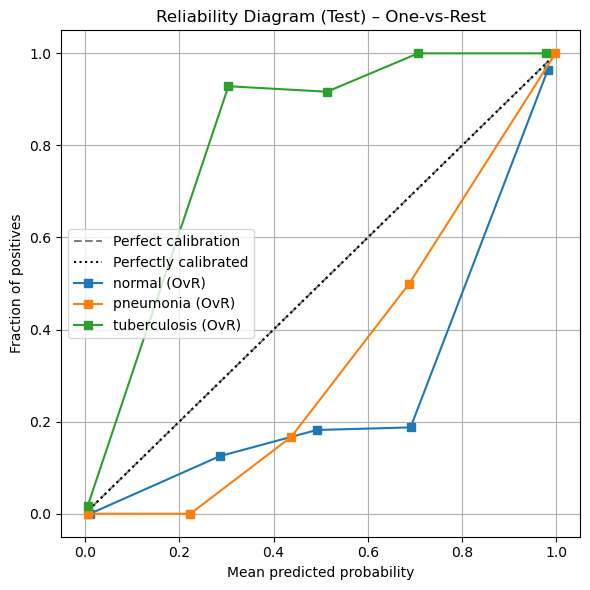

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
from chestxray_module.dataset import load_split


# NUM_CLASSES = 3
# CLASS_NAMES = ["normal", "pneumonia", "tuberculosis"]  # must match your CLASS_TO_IDX order
# CHECKPOINT_PATH = f"{os.getcwd()}/models/best_model.pt"
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# BATCH_SIZE = 32
# NUM_WORKERS = 0

# test_dataset = load_split("test")

# test_loader = DataLoader(
#     test_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=NUM_WORKERS,
#     pin_memory=True,
# )


# model = models.densenet121(weights=None)
# in_features = model.classifier.in_features
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(in_features, NUM_CLASSES)
# )

# model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
# model.to(DEVICE)
# model.eval()


all_probs = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(DEVICE)

        # Ensure correct dtype for the model (float)
        if images.dtype != torch.float32:
            images = images.float()

        # labels must be numeric long tensor already (B,)
        labels = batch["class"].to(DEVICE).long()

        logits = model(images)                      # (B, C)
        probs = torch.softmax(logits, dim=1)        # (B, C)

        all_probs.append(probs.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)       # (N, C)
all_targets = np.concatenate(all_targets, axis=0)   # (N,)

print("all_probs shape:", all_probs.shape)
print("all_targets shape:", all_targets.shape)
print("unique targets:", set(all_targets.tolist()))



fig, ax = plt.subplots(figsize=(6, 6))

# Perfect calibration line
ax.plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")

for class_idx, class_name in enumerate(CLASS_NAMES):
    # One-vs-rest labels
    y_true_bin = (all_targets == class_idx).astype(int)
    y_prob_bin = all_probs[:, class_idx]

    CalibrationDisplay.from_predictions(
        y_true_bin,
        y_prob_bin,
        n_bins=5,
        strategy="uniform",
        name=f"{class_name} (OvR)",
        ax=ax,
    )

ax.set_title("Reliability Diagram (Test) – One-vs-Rest")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.grid(False)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# From test evaluation
# all_probs: shape (N, 3)
# all_targets: shape (N,)



# import matplotlib.pyplot as plt

# TB_IDX = 2
# y_true = (all_targets == TB_IDX).astype(int)
# y_prob = all_probs[:, TB_IDX]


# import numpy as np
# from sklearn.metrics import recall_score, precision_score

# thresholds = np.linspace(0.0, 1.0, 101)

# sensitivities = []
# specificities = []

# for t in thresholds:
#     y_pred = (y_prob >= t).astype(int)

#     sensitivity = recall_score(y_true, y_pred)  # TP / (TP + FN)
#     specificity = recall_score(y_true, y_pred, pos_label=0)  # TN / (TN + FP)

#     sensitivities.append(sensitivity)
#     specificities.append(specificity)


# plt.figure(figsize=(6, 4))
# plt.plot(thresholds, sensitivities, label="Sensitivity (Recall)")
# plt.plot(thresholds, specificities, label="Specificity")
# plt.xlabel("Probability Threshold")
# plt.ylabel("Score")
# plt.title("Threshold Analysis – Tuberculosis (Test)")
# plt.legend()
# plt.grid(False)
# plt.tight_layout()
# plt.show()


######
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Plot 1: Absolute counts ---
plt.figure(figsize=(6, 4))
plt.plot(thresholds, sensitivities, label="Sensitivity (Recall)")
plt.plot(thresholds, specificities, label="Specificity")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Threshold Analysis – Tuberculosis (Test)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()
axes[0].set_title("Class distribution/split (Absolute Counts)")
axes[0].set_xlabel("Split")
axes[0].set_ylabel("Number of Images")

# --- Plot 2: Percentages ---
TB_IDX = 3
y_true = (all_targets == TB_IDX).astype(int)
y_prob = all_probs[:, TB_IDX]


import numpy as np
from sklearn.metrics import recall_score, precision_score

thresholds = np.linspace(0.0, 1.0, 101)

sensitivities = []
specificities = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)

    sensitivity = recall_score(y_true, y_pred)  # TP / (TP + FN)
    specificity = recall_score(y_true, y_pred, pos_label=0)  # TN / (TN + FP)

    sensitivities.append(sensitivity)
    specificities.append(specificity)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, sensitivities, label="Sensitivity (Recall)")
plt.plot(thresholds, specificities, label="Specificity")
plt.xlabel("Probability Threshold")
plt.ylabel("Score")
plt.title("Threshold Analysis – Tuberculosis (Test)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()
axes[0].set_title("Class distribution/split (Absolute Counts)")
axes[0].set_xlabel("Split")
axes[0].set_ylabel("Number of Images")
axes[1].set_title("Class distribution/split (Percentages)")
axes[1].set_xlabel("Split")
axes[1].set_ylabel("Percentage of Images (%)")

# Handle legends (avoid duplication)
axes[0].legend(title="Class")
# axes[1].legend_.remove()

plt.tight_layout()
plt.show()

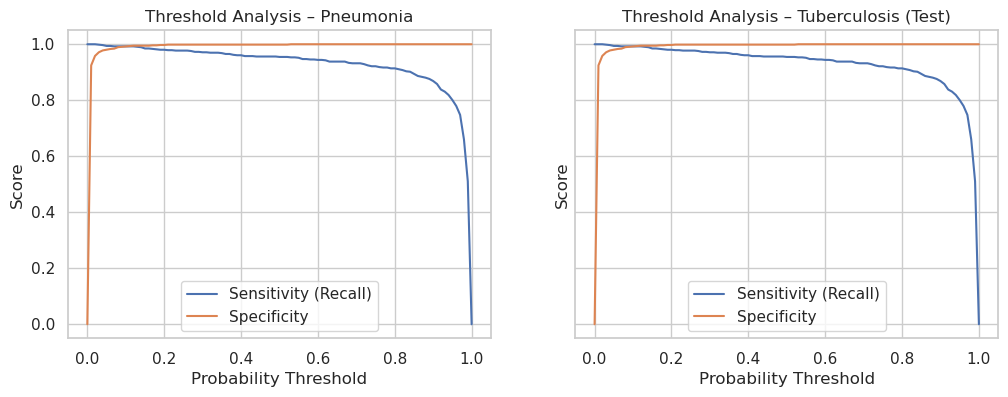

In [53]:
import numpy as np
from sklearn.metrics import recall_score

PN_IDX = 1
y_true = (all_targets == TB_IDX).astype(int)
y_prob = all_probs[:, TB_IDX]

thresholds = np.linspace(0.0, 1.0, 101)

sensitivities = []
specificities = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)

    sensitivity = recall_score(y_true, y_pred)  # TP / (TP + FN)
    specificity = recall_score(y_true, y_pred, pos_label=0)  # TN / (TN + FP)

    sensitivities.append(sensitivity)
    specificities.append(specificity)
    
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)   

axes[0].plot(thresholds, sensitivities, label="Sensitivity (Recall)")
axes[0].plot(thresholds, specificities, label="Specificity")
axes[0].set_xlabel("Probability Threshold")
axes[0].set_ylabel("Score")
axes[0].set_title("Threshold Analysis – Pneumonia")
axes[0].legend()



TB_IDX = 2
y_true = (all_targets == TB_IDX).astype(int)
y_prob = all_probs[:, TB_IDX]

thresholds = np.linspace(0.0, 1.0, 101)

sensitivities = []
specificities = []

for t in thresholds:
    y_pred = (y_prob >= t).astype(int)

    sensitivity = recall_score(y_true, y_pred)  # TP / (TP + FN)
    specificity = recall_score(y_true, y_pred, pos_label=0)  # TN / (TN + FP)

    sensitivities.append(sensitivity)
    specificities.append(specificity)


axes[1].plot(thresholds, sensitivities, label="Sensitivity (Recall)")
axes[1].plot(thresholds, specificities, label="Specificity")
axes[1].set_xlabel("Probability Threshold")
axes[1].set_ylabel("Score")
axes[1].set_title("Threshold Analysis – Tuberculosis (Test)")
axes[1].legend()

plt.show()
